# Deep Learning & Art: Neural Style Transfer

Welcome to the second assignment of this week. In this assignment, you will learn about Neural Style Transfer. This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

**In this assignment, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize a cost function to get pixel values!

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import imageio                         # try this if you got error on 'scipy.misc' has no attribute 'imread'

%matplotlib inline

C:\Users\user\anaconda3\envs\py37_tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\anaconda3\envs\py37_tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\anaconda3\envs\py37_tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\anaconda3\envs\py37_tf\lib\site-packages\tensorflow\pyth

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [3]:
# download imagenet-vgg-verydeep-19.mat from the web and store in a directory ./pretrained-model
# http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat
"""
if you encounter some error of assertion error, it might caused by the new formate in updated .mat file, 
might need to figure out the configuration by yourself, take my example :

the original code in "nst_utils.py" is 
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]

how ever I've modified the code as following, after I figure out the format that I've downloaded
        wb = vgg_layers[0][layer]  # layer = 0,1,2... define as below graph{}
        W = wb[0][0][0][0][0]
        b = wb[0][0][0][0][1]
        layer_name = vgg_layers[0][layer][0][0][3]
"""
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)


{'input': <tf.Variable 'Variable_1:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_24:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 

The model is stored in a python dictionary where each variable name is the key and the corresponding value is a tensor containing that variable's value. To run an image through this network, you just have to feed the image to the model. In TensorFlow, you can do so using the [tf.assign](https://www.tensorflow.org/api_docs/python/tf/assign) function. In particular, you will use the assign function like this:  
```python
model["input"].assign(image)
```
This assigns the image as an input to the model. After this, if you want to access the activations of a particular layer, say layer `4_2` when the network is run on this image, you would run a TensorFlow session on the correct tensor `conv4_2`, as follows:  
```python
sess.run(model["conv4_2"])
```

## 3 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

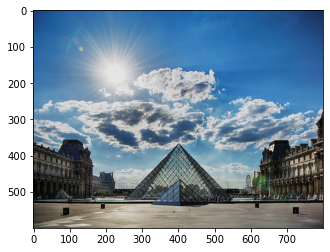

In [4]:
#content_image = scipy.misc.imread("images/louvre.jpg")
content_image = imageio.imread(os.path.join("images", "louvre.jpg"))         # try this if you got error on 'scipy.misc' has no attribute 'imread'

imshow(content_image)

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.

** 3.1.1 - How do you ensure the generated image G matches the content of the image C?**

As we saw in lecture, the earlier (shallower) layers of a ConvNet tend to detect lower-level features such as edges and simple textures, and the later (deeper) layers tend to detect higher-level features such as more complex textures as well as object classes. 

We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. In practice, you'll get the most visually pleasing results if you choose a layer in the middle of the network--neither too shallow nor too deep. (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

So, suppose you have picked one particular hidden layer to use. Now, set the image C as the input to the pretrained VGG network, and run forward propagation. Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be a $n_H \times n_W \times n_C$ tensor. Repeat this process with the image G: Set G as the input, and run forward progation. Let $$a^{(G)}$$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the volumes corresponding to a hidden layer's activations. In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below. (Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style const $J_{style}$.)

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

**Exercise:** Compute the "content cost" using TensorFlow. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from a_G: 
    - To retrieve dimensions from a tensor X, use: `X.get_shape().as_list()`
2. Unroll a_C and a_G as explained in the picture above
    - If you are stuck, take a look at [Hint1](https://www.tensorflow.org/versions/r1.3/api_docs/python/tf/transpose) and [Hint2](https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/reshape).
3. Compute the content cost:
    - If you are stuck, take a look at [Hint3](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [Hint4](https://www.tensorflow.org/api_docs/python/tf/square) and [Hint5](https://www.tensorflow.org/api_docs/python/tf/subtract).

In [5]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[n_H * n_W, n_C]))
    # compute the cost with tensorflow (≈1 line)
    J_content = 1 / (4 * n_H * n_W * n_C)*tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))
    ### END CODE HERE ###
    
    return J_content, a_C_unrolled, a_G_unrolled

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content, a_C_unrolled, a_G_unrolled = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content, a_C_unrolled, a_G_unrolled = compute_content_cost(a_C, a_G)
    print("a_C_unrolled = " + str(a_C_unrolled.eval()))

tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content, a_C_unrolled, a_G_unrolled = compute_content_cost(a_C, a_G)
    print("a_G_unrolled = " + str(a_G_unrolled.eval()))
    
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content, a_C_unrolled, a_G_unrolled = compute_content_cost(a_C, a_G)
    print("a_C_unrolled-a_G_unrolled = " + str(a_C_unrolled.eval()-a_G_unrolled.eval()))

**Expected Output**:

<table>
    <tr>
        <td>
            **J_content**
        </td>
        <td>
           6.76559
        </td>
    </tr>

</table>

<font color='blue'>
**What you should remember**:
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

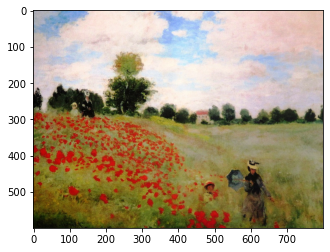

In [6]:
import imageio                         # try this if you got error on 'scipy.misc' has no attribute 'imread'
#style_image = scipy.misc.imread("images/monet_800600.jpg"){}
style_image = imageio.imread(os.path.join("images", "monet_800600.jpg"))         # try this if you got error on 'scipy.misc' has no attribute 'imread'

imshow(style_image)

This painting was painted in the style of *[impressionism](https://en.wikipedia.org/wiki/Impressionism)*.

Lets see how you can now define a "style" const function $J_{style}(S,G)$. 

### 3.2.1 - Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context. 

In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image. 

**Exercise**:
Using TensorFlow, implement a function that computes the Gram matrix of a matrix A. The formula is: The gram matrix of A is $G_A = AA^T$. If you are stuck, take a look at [Hint 1](https://www.tensorflow.org/api_docs/python/tf/matmul) and [Hint 2](https://www.tensorflow.org/api_docs/python/tf/transpose).

In [7]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A, tf.transpose(A))
    GA = tf.clip_by_value(GA, -10000000000, 10000000000)   # try to avoid gradient explore
    ### END CODE HERE ###
    
    return GA

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

**Expected Output**:

<table>
    <tr>
        <td>
            **GA**
        </td>
        <td>
           [[  6.42230511  -4.42912197  -2.09668207] <br>
 [ -4.42912197  19.46583748  19.56387138] <br>
 [ -2.09668207  19.56387138  20.6864624 ]]
        </td>
    </tr>

</table>

### 3.2.2 - Style cost

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


**Exercise**: Compute the style cost for a single layer. 

**Instructions**: The 3 steps to implement this function are:
1. Retrieve dimensions from the hidden layer activations a_G: 
    - To retrieve dimensions from a tensor X, use: `X.get_shape().as_list()`
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above.
    - You may find [Hint1](https://www.tensorflow.org/versions/r1.3/api_docs/python/tf/transpose) and [Hint2](https://www.tensorflow.org/versions/r1.2/api_docs/python/tf/reshape) useful.
3. Compute the Style matrix of the images S and G. (Use the function you had previously written.) 
4. Compute the Style cost:
    - You may find [Hint3](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [Hint4](https://www.tensorflow.org/api_docs/python/tf/square) and [Hint5](https://www.tensorflow.org/api_docs/python/tf/subtract) useful.

In [8]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, shape = [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape = [n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    #J_style_layer = 1 / (2*n_C*n_H*n_W)**2 * tf.reduce_sum(tf.square(GS-GG)) #1 / (4 * tf.square(n_C) * tf.square(n_H * n_W))*tf.reduce_sum(tf.square(GS - GG))
    J_style_layer = 1 / (2*n_C*n_H*n_W)**2 * tf.reduce_sum(GS-GG) #1 / (4 * tf.square(n_C) * tf.square(n_H * n_W))*tf.reduce_sum(tf.square(GS - GG))

    ### END CODE HERE ###
    
    return J_style_layer, GS, GG

In [ ]:
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer, GS, GG = compute_layer_style_cost(a_S, a_G)
    print("J_style_layer = " + str(J_style_layer.eval()))
    
    
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer, GS, GG = compute_layer_style_cost(a_S, a_G)
    print("GS = " + str(GS.eval()))
    
    
tf.reset_default_graph()
with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer, GS, GG = compute_layer_style_cost(a_S, a_G)
    print("GG = " + str(GG.eval()))

**Expected Output**:

<table>
    <tr>
        <td>
            **J_style_layer**
        </td>
        <td>
           9.19028
        </td>
    </tr>

</table>

### 3.2.3 Style Weights

So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$. But for now, this is a pretty reasonable default: 

In [9]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


We've implemented a compute_style_cost(...) function. It simply calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. Read over it to make sure you understand what it's doing. 

<!-- 
2. Loop over (layer_name, coeff) from STYLE_LAYERS:
        a. Select the output tensor of the current layer. As an example, to call the tensor from the "conv1_1" layer you would do: out = model["conv1_1"]
        b. Get the style of the style image from the current layer by running the session on the tensor "out"
        c. Get a tensor representing the style of the generated image from the current layer. It is just "out".
        d. Now that you have both styles. Use the function you've implemented above to compute the style_cost for the current layer
        e. Add (style_cost x coeff) of the current layer to overall style cost (J_style)
3. Return J_style, which should now be the sum of the (style_cost x coeff) for each layer.
!--> 


In [10]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        GS_list = []
        GG_list = []

        # Select the output tensor of the currently selected layer
        #out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        #a_S = sess.run(out)
        a_S = sess.run(model[layer_name])

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        #a_G = out
        a_G = model[layer_name]
        #print("a_G = ",sess.run(a_G))
        
        # Compute style_cost for the current layer
        J_style_layer, GS, GG = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer
        GS_list.append(GS)
        GG_list.append(GG)
        #print("J_style = " + str(J_style.eval()))
        #print("GS_list = " + str(GS_list))
        #print("GG_list = " + str(GG_list))

    return J_style, GS_list, GG_list

**Note**: In the inner-loop of the for-loop above, `a_G` is a tensor and hasn't been evaluated yet. It will be evaluated and updated at each iteration when we run the TensorFlow graph in model_nn() below.

<!-- 
How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers
!-->


<font color='blue'>
**What you should remember**:
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. However, we get even better results combining this representation from multiple different layers. This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 
</font color='blue'>



### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. 

In [11]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

In [ ]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

**Expected Output**:

<table>
    <tr>
        <td>
            **J**
        </td>
        <td>
           35.34667875478276
        </td>
    </tr>

</table>

<font color='blue'>
**What you should remember**:
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style

## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:
<font color='purple'>

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>

Lets go through the individual steps in detail. 

You've previously implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. To do so, your program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  This allows you to run variables without constantly needing to refer to the session object, which simplifies the code.  

Lets start the interactive session.

In [12]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [13]:
#content_image = scipy.misc.imread("images/louvre_small.jpg")
content_image = imageio.imread(os.path.join("images", "louvre_small.jpg"))         # try this if you got error on 'scipy.misc' has no attribute 'imread'
content_image = reshape_and_normalize_image(content_image)                         # also add dimension as [m, h, w, c]

Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [14]:
#style_image = scipy.misc.imread("images/monet.jpg")
style_image = imageio.imread(os.path.join("images", "monet.jpg"))         # try this if you got error on 'scipy.misc' has no attribute 'imread'
style_image = reshape_and_normalize_image(style_image)                    # also add dimension as [m, h, w, c]

Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. (Feel free to look in `nst_utils.py` to see the details of `generate_noise_image(...)`; to do so, click "File-->Open..." at the upper-left corner of this Jupyter notebook.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


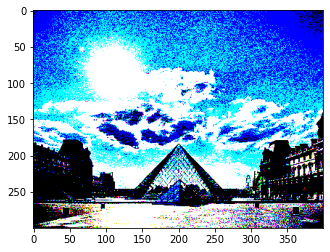

In [15]:
generated_image = generate_noise_image(content_image)
#generated_image = tf.Variable(initial_value = generated_image, dtype="float32")
imshow(generated_image[0]);

Next, as explained in part (2), let's load the VGG16 model.

In [16]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [17]:
# Assign the content image to be the input of the VGG model.
sess.run(model["input"].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv1_1']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content, a_C_unrolled, a_G_unrolled = compute_content_cost(a_C, a_G)

**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [18]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style, GS_list, GG_list = compute_style_cost(model, STYLE_LAYERS)

**Exercise**: Now that you have J_content and J_style, compute the total cost J by calling `total_cost()`. Use `alpha = 10` and `beta = 40`.

In [19]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style)
### END CODE HERE ###

You'd previously learned how to set up the Adam optimizer in TensorFlow. Lets do that here, using a learning rate of 2.0.  [See reference](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

In [20]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001, epsilon = 1e-05)
# define train_step (1 line)
#global_step = tf.Variable(0, name='global_step', trainable=False)
train_step = optimizer.minimize(J)    # ok
#gvs = optimizer.compute_gradients(J)
#gradients, variables = zip(*optimizer.compute_gradients(J))
#gradients, _ = tf.clip_by_global_norm(gradients, 999.0)
#train_step = optimizer.apply_gradients(zip(gradients, variables))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Exercise**: Implement the model_nn() function which initializes the variables of the tensorflow graph, assigns the input image (initial generated image) as the input of the VGG16 model and runs the train_step for a large number of steps.

In [ ]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    #sess.run(tf.global_variables_initializer())
    init_op = tf.initialize_all_variables()
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(init_op)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        #sess.run(train_step)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        print("a_C_unrolled = ",sess.run(a_C_unrolled))
        print("a_G_unrolled = ",sess.run(a_G_unrolled))
        print("GS_list = ",sess.run(GS_list))
        print("GG_list = ",sess.run(GG_list))
        print("J = ",sess.run(J))
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Instructions for updating:
Use `tf.global_variables_initializer` instead.


'generated_image = '

Array([[[-42.45032417, -16.23369663,  -5.87690634],
        [-38.82901351, -12.68184498,   9.00065036],
        [-43.73954389, -12.49205769,  -0.63647637],
        ...,
        [-28.34436347, -20.4037957 , -12.68088507],
        [-37.46698844, -16.20950211,   5.15687204],
        [-33.3573941 , -23.496817  ,  -8.03466296]],

       [[-45.44943225, -23.94717878,  15.30773549],
        [-28.88332793, -15.25846556,   4.28813495],
        [-31.27468869, -27.21770657,   4.45221224],
        ...,
        [-38.12912097, -29.61143397,  -5.79859626],
        [-47.17524278, -16.07768524,  -4.99262464],
        [-46.99007117, -35.20338953,   1.66910387]],

       [[-34.56270215, -26.44520834,  14.40948244],
        [-45.30127771, -21.87361975,  10.79958139],
        [-32.50220163, -22.21830664,  -4.53330416],
        ...,
        [-45.96041143, -32.1604739 ,  -6.99807391],
        [-33.3307142 , -38.35610531, -14.25790247],
        [-29.37999904, -33.20297039,  -0.65729475]],

       ...,

      

a_C_unrolled =  [[140.70317    107.45617    105.12337    ...  -0.          -0.
   -0.        ]
 [ 35.643764    49.380577    50.56549    ...  -0.          -0.
   -0.        ]
 [  3.4616046   -0.          -0.         ...  -0.          -0.
   -0.        ]
 ...
 [ 46.861485    72.59455     70.76873    ... 113.39476    115.304794
   68.263405  ]
 [ -0.          -0.          -0.         ...  50.50196     49.07713
   -0.        ]
 [  0.25346297  -0.          -0.         ...  -0.          -0.
   -0.        ]]
a_G =  [[[[43.586266   13.836354   -0.         ... 16.015644   -0.
    -0.        ]
   [38.55347    20.547083   -0.         ... 28.922565   -0.
    -0.        ]
   [46.445133   19.719936   -0.         ... 26.256016   -0.
    -0.        ]
   ...
   [42.684013    7.5482035  -0.         ... 37.545097   -0.
    -0.        ]
   [61.97224    13.946376   -0.         ... 37.721878   -0.
    -0.        ]
   [ 9.3446455   5.3368654  -0.         ... 20.593979   -0.
    -0.        ]]

  [[26.226303  

GG_list =  [array([[1.4719725e+04, 7.8344893e+03, 2.4512151e+03, ..., 1.9479325e+03,
        6.3652039e+02, 8.1039546e+03],
       [7.8344893e+03, 2.3244184e+04, 1.3550344e+03, ..., 5.0734062e+03,
        6.6051590e+01, 1.2774551e+04],
       [2.4512151e+03, 1.3550344e+03, 2.4000977e+04, ..., 4.1686787e+03,
        8.9667084e+02, 8.5789639e+03],
       ...,
       [1.9479326e+03, 5.0734058e+03, 4.1686782e+03, ..., 4.0467391e+04,
        2.5925745e+02, 9.7251465e+03],
       [6.3652039e+02, 6.6051590e+01, 8.9667084e+02, ..., 2.5925745e+02,
        4.0690765e+02, 1.7157114e+02],
       [8.1039541e+03, 1.2774551e+04, 8.5789639e+03, ..., 9.7251465e+03,
        1.7157114e+02, 6.8344406e+04]], dtype=float32)]
content cost =  252.80287
style cost =  0.85736954
J =  2562.3235


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


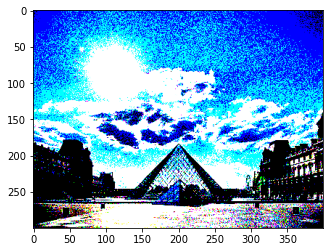

In [21]:
#sess.run(tf.global_variables_initializer())
#sess.run(model['input'].assign(generated_image))
#display(generated_image[0])
#print("J = ",sess.run(J))
#sess.run(train_step)
#print("J = ",sess.run(J))
#generated_image = sess.run(model['input'])
#display(generated_image.shape)
#display(generated_image[0].shape)
#display(generated_image[0])
#imshow(generated_image[0])

# Add the optimizer
#train_op = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
# Add the ops to initialize variables.  These will include 
# the optimizer slots added by AdamOptimizer().
init_op = tf.initialize_all_variables() 
#init_op = tf.global_variables_initializer()
# Actually intialize the variables
sess.run(init_op)
#tvars = tf.trainable_variables()
#grads, _ = tf.clip_by_global_norm(tf.gradients(total_loss, tvars), 100)
# launch the graph in a session
#sess = tf.Session()                               ##### restart 關掉可行, 2nd run 啟動,關掉都nan
#model['input'].assign(generated_image) # NG
sess.run(model['input'].assign(generated_image))
display("generated_image = ",generated_image[0])
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G = ", sess.run(a_G))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("content cost = ",sess.run(J_content))
print("style cost = ",sess.run(J_style))
print("J = ",sess.run(J))
# now train your model
sess.run(train_step)
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G = ", sess.run(a_G))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("content cost = ",sess.run(J_content))
print("style cost = ",sess.run(J_style))
print("J = ",sess.run(J))
generated_image = sess.run(model['input'])
#display(generated_image.shape)
#display("generated_image = ",generated_image[0])
imshow(generated_image[0])

a_C_unrolled =  [[140.70317    107.45617    105.12337    ...  -0.          -0.
   -0.        ]
 [ 35.643764    49.380577    50.56549    ...  -0.          -0.
   -0.        ]
 [  3.4616046   -0.          -0.         ...  -0.          -0.
   -0.        ]
 ...
 [ 46.861485    72.59455     70.76873    ... 113.39476    115.304794
   68.263405  ]
 [ -0.          -0.          -0.         ...  50.50196     49.07713
   -0.        ]
 [  0.25346297  -0.          -0.         ...  -0.          -0.
   -0.        ]]
a_G =  [[[[43.586292   13.836365   -0.         ... 16.015652   -0.
    -0.        ]
   [38.55351    20.547104   -0.         ... 28.922583   -0.
    -0.        ]
   [46.445164   19.719955   -0.         ... 26.256027   -0.
    -0.        ]
   ...
   [42.68405     7.5482073  -0.         ... 37.545124   -0.
    -0.        ]
   [61.97227    13.946374   -0.         ... 37.721897   -0.
    -0.        ]
   [ 9.34464     5.336859   -0.         ... 20.59399    -0.
    -0.        ]]

  [[26.22631   

GG_list =  [array([[1.4719715e+04, 7.8344917e+03, 2.4512087e+03, ..., 1.9479348e+03,
        6.3652069e+02, 8.1039731e+03],
       [7.8344917e+03, 2.3244230e+04, 1.3550305e+03, ..., 5.0734185e+03,
        6.6052284e+01, 1.2774589e+04],
       [2.4512087e+03, 1.3550305e+03, 2.4000969e+04, ..., 4.1686772e+03,
        8.9667273e+02, 8.5789658e+03],
       ...,
       [1.9479348e+03, 5.0734180e+03, 4.1686772e+03, ..., 4.0467426e+04,
        2.5925641e+02, 9.7251631e+03],
       [6.3652069e+02, 6.6052284e+01, 8.9667273e+02, ..., 2.5925641e+02,
        4.0690869e+02, 1.7157138e+02],
       [8.1039727e+03, 1.2774591e+04, 8.5789648e+03, ..., 9.7251631e+03,
        1.7157138e+02, 6.8344531e+04]], dtype=float32)]
content cost =  252.80293
style cost =  0.85736954


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


J =  2562.324


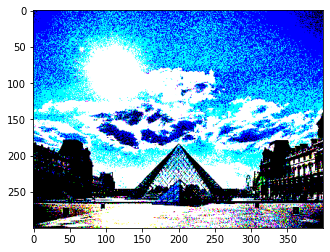

In [22]:
#display(generated_image[0])
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G = ", sess.run(a_G))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("content cost = ",sess.run(J_content))
print("style cost = ",sess.run(J_style))
print("J = ",sess.run(J))
# now train your model
sess.run(train_step)
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G = ", sess.run(a_G))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("content cost = ",sess.run(J_content))
print("style cost = ",sess.run(J_style))
print("J = ",sess.run(J))
generated_image = sess.run(model['input'])
#display(generated_image.shape)
#display(generated_image[0])
imshow(generated_image[0])

array([[[-42.450424  , -16.233757  ,  -5.8769846 ],
        [-38.829124  , -12.681911  ,   9.000594  ],
        [-43.739647  , -12.492136  ,  -0.6365567 ],
        ...,
        [-28.34446   , -20.403877  , -12.680975  ],
        [-37.467087  , -16.209585  ,   5.1567793 ],
        [-33.357487  , -23.49691   ,  -8.034758  ]],

       [[-45.449524  , -23.947266  ,  15.307646  ],
        [-28.883425  , -15.258564  ,   4.2880883 ],
        [-31.274782  , -27.217806  ,   4.452157  ],
        ...,
        [-38.12921   , -29.611542  ,  -5.798662  ],
        [-47.175335  , -16.077791  ,  -4.9926987 ],
        [-46.990143  , -35.203495  ,   1.6690356 ]],

       [[-34.562786  , -26.445274  ,  14.409399  ],
        [-45.301365  , -21.873707  ,  10.799535  ],
        [-32.502296  , -22.218388  ,  -4.533354  ],
        ...,
        [-45.960506  , -32.160553  ,  -6.9981275 ],
        [-33.330814  , -38.3562    , -14.257968  ],
        [-29.380087  , -33.203068  ,  -0.65736073]],

       ...,

      

a_C_unrolled =  [[140.70317    107.45617    105.12337    ...  -0.          -0.
   -0.        ]
 [ 35.643764    49.380577    50.56549    ...  -0.          -0.
   -0.        ]
 [  3.4616046   -0.          -0.         ...  -0.          -0.
   -0.        ]
 ...
 [ 46.861485    72.59455     70.76873    ... 113.39476    115.304794
   68.263405  ]
 [ -0.          -0.          -0.         ...  50.50196     49.07713
   -0.        ]
 [  0.25346297  -0.          -0.         ...  -0.          -0.
   -0.        ]]
a_G_unrolled =  [[43.5865   38.55367  46.44533  ... -0.       -0.       -0.      ]
 [13.836349 20.547071 19.719927 ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 ...
 [16.015728 28.922705 26.256153 ... 42.946774 48.298977 27.499498]
 [-0.       -0.       -0.       ... 20.17424  28.97984  -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]]
GS_list =  [array([[ 75195.75   ,   1094.3505 ,   5930.756  , ...,   

(1, 300, 400, 3)

array([[[-42.45038   , -16.233704  ,  -5.87693   ],
        [-38.829075  , -12.681864  ,   9.000646  ],
        [-43.7396    , -12.492085  ,  -0.63650995],
        ...,
        [-28.344414  , -20.403833  , -12.680927  ],
        [-37.467045  , -16.209541  ,   5.156817  ],
        [-33.357445  , -23.49687   ,  -8.034732  ]],

       [[-45.44948   , -23.947212  ,  15.307696  ],
        [-28.883377  , -15.2585125 ,   4.288139  ],
        [-31.274734  , -27.217752  ,   4.452205  ],
        ...,
        [-38.12917   , -29.611492  ,  -5.7986116 ],
        [-47.17529   , -16.077744  ,  -4.992653  ],
        [-46.9901    , -35.20345   ,   1.6690704 ]],

       [[-34.562737  , -26.44522   ,  14.4094515 ],
        [-45.301315  , -21.873652  ,  10.799585  ],
        [-32.502247  , -22.218334  ,  -4.533308  ],
        ...,
        [-45.960464  , -32.1605    ,  -6.998081  ],
        [-33.330765  , -38.35615   , -14.257919  ],
        [-29.38004   , -33.203022  ,  -0.65731394]],

       ...,

      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


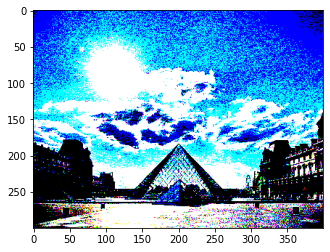

In [23]:
display(generated_image[0])
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("J = ",sess.run(J))
# now train your model
sess.run(train_step)
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("J = ",sess.run(J))
generated_image = sess.run(model['input'])
display(generated_image.shape)
display(generated_image[0])
imshow(generated_image[0])

array([[[-42.45038   , -16.233704  ,  -5.87693   ],
        [-38.829075  , -12.681864  ,   9.000646  ],
        [-43.7396    , -12.492085  ,  -0.63650995],
        ...,
        [-28.344414  , -20.403833  , -12.680927  ],
        [-37.467045  , -16.209541  ,   5.156817  ],
        [-33.357445  , -23.49687   ,  -8.034732  ]],

       [[-45.44948   , -23.947212  ,  15.307696  ],
        [-28.883377  , -15.2585125 ,   4.288139  ],
        [-31.274734  , -27.217752  ,   4.452205  ],
        ...,
        [-38.12917   , -29.611492  ,  -5.7986116 ],
        [-47.17529   , -16.077744  ,  -4.992653  ],
        [-46.9901    , -35.20345   ,   1.6690704 ]],

       [[-34.562737  , -26.44522   ,  14.4094515 ],
        [-45.301315  , -21.873652  ,  10.799585  ],
        [-32.502247  , -22.218334  ,  -4.533308  ],
        ...,
        [-45.960464  , -32.1605    ,  -6.998081  ],
        [-33.330765  , -38.35615   , -14.257919  ],
        [-29.38004   , -33.203022  ,  -0.65731394]],

       ...,

      

a_C_unrolled =  [[140.70317    107.45617    105.12337    ...  -0.          -0.
   -0.        ]
 [ 35.643764    49.380577    50.56549    ...  -0.          -0.
   -0.        ]
 [  3.4616046   -0.          -0.         ...  -0.          -0.
   -0.        ]
 ...
 [ 46.861485    72.59455     70.76873    ... 113.39476    115.304794
   68.263405  ]
 [ -0.          -0.          -0.         ...  50.50196     49.07713
   -0.        ]
 [  0.25346297  -0.          -0.         ...  -0.          -0.
   -0.        ]]
a_G_unrolled =  [[43.586365 38.55356  46.44522  ... -0.       -0.       -0.      ]
 [13.836361 20.547094 19.719946 ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 ...
 [16.015678 28.922617 26.256073 ... 42.946686 48.298897 27.49945 ]
 [-0.       -0.       -0.       ... 20.174206 28.979801 -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]]
GS_list =  [array([[ 75195.75   ,   1094.3505 ,   5930.756  , ...,   

(1, 300, 400, 3)

array([[[-42.45031   , -16.233631  ,  -5.8768578 ],
        [-38.829006  , -12.681794  ,   9.000717  ],
        [-43.739532  , -12.492014  ,  -0.63644046],
        ...,
        [-28.344345  , -20.403765  , -12.680858  ],
        [-37.466976  , -16.209473  ,   5.156883  ],
        [-33.357376  , -23.496803  ,  -8.03467   ]],

       [[-45.44941   , -23.94714   ,  15.307768  ],
        [-28.883307  , -15.258441  ,   4.2882104 ],
        [-31.274664  , -27.21768   ,   4.4522753 ],
        ...,
        [-38.1291    , -29.611422  ,  -5.7985406 ],
        [-47.17522   , -16.077673  ,  -4.9925838 ],
        [-46.990032  , -35.20338   ,   1.669135  ]],

       [[-34.562668  , -26.445148  ,  14.409523  ],
        [-45.301243  , -21.873579  ,  10.799657  ],
        [-32.502174  , -22.218262  ,  -4.533239  ],
        ...,
        [-45.960396  , -32.160427  ,  -6.998012  ],
        [-33.330696  , -38.35608   , -14.257849  ],
        [-29.379969  , -33.202953  ,  -0.6572443 ]],

       ...,

      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


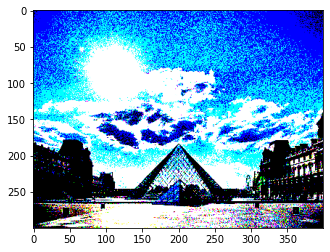

In [24]:
display(generated_image[0])
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("J = ",sess.run(J))
# now train your model
sess.run(train_step)
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("J = ",sess.run(J))
generated_image = sess.run(model['input'])
display(generated_image.shape)
display(generated_image[0])
imshow(generated_image[0])

array([[[-42.45015   , -16.233461  ,  -5.876689  ],
        [-38.828846  , -12.681632  ,   9.000884  ],
        [-43.739372  , -12.491847  ,  -0.63627857],
        ...,
        [-28.344185  , -20.403605  , -12.680695  ],
        [-37.466816  , -16.209314  ,   5.157035  ],
        [-33.35722   , -23.496649  ,  -8.034529  ]],

       [[-45.44925   , -23.94697   ,  15.307934  ],
        [-28.883142  , -15.258273  ,   4.288377  ],
        [-31.2745    , -27.217512  ,   4.452439  ],
        ...,
        [-38.128944  , -29.611256  ,  -5.7983747 ],
        [-47.17506   , -16.077509  ,  -4.9924226 ],
        [-46.989872  , -35.20322   ,   1.6692841 ]],

       [[-34.562504  , -26.444979  ,  14.409691  ],
        [-45.301075  , -21.87341   ,  10.799824  ],
        [-32.502007  , -22.218092  ,  -4.533078  ],
        ...,
        [-45.960236  , -32.16026   ,  -6.997851  ],
        [-33.330536  , -38.35591   , -14.257684  ],
        [-29.379805  , -33.20279   ,  -0.65708226]],

       ...,

      

a_C_unrolled =  [[140.70317    107.45617    105.12337    ...  -0.          -0.
   -0.        ]
 [ 35.643764    49.380577    50.56549    ...  -0.          -0.
   -0.        ]
 [  3.4616046   -0.          -0.         ...  -0.          -0.
   -0.        ]
 ...
 [ 46.861485    72.59455     70.76873    ... 113.39476    115.304794
   68.263405  ]
 [ -0.          -0.          -0.         ...  50.50196     49.07713
   -0.        ]
 [  0.25346297  -0.          -0.         ...  -0.          -0.
   -0.        ]]
a_G_unrolled =  [[43.58571  38.553043 46.444702 ... -0.       -0.       -0.      ]
 [13.836421 20.547194 19.720041 ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 ...
 [16.015429 28.922232 26.255684 ... 42.9463   48.298508 27.499222]
 [-0.       -0.       -0.       ... 20.174042 28.97964  -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]]
GS_list =  [array([[ 75195.75   ,   1094.3505 ,   5930.756  , ...,   

(1, 300, 400, 3)

array([[[-42.45006  , -16.233372 ,  -5.8765984],
        [-38.828754 , -12.681542 ,   9.000975 ],
        [-43.739285 , -12.491756 ,  -0.6361891],
        ...,
        [-28.344095 , -20.403515 , -12.680605 ],
        [-37.46673  , -16.209227 ,   5.1571217],
        [-33.357132 , -23.496561 ,  -8.034445 ]],

       [[-45.44916  , -23.946878 ,  15.308024 ],
        [-28.883053 , -15.258183 ,   4.2884674],
        [-31.27441  , -27.21742  ,   4.452529 ],
        ...,
        [-38.128857 , -29.611166 ,  -5.798284 ],
        [-47.174973 , -16.07742  ,  -4.9923334],
        [-46.989784 , -35.203133 ,   1.6693699]],

       [[-34.562412 , -26.444887 ,  14.409781 ],
        [-45.300983 , -21.87332  ,  10.799914 ],
        [-32.501915 , -22.218    ,  -4.532989 ],
        ...,
        [-45.960148 , -32.160168 ,  -6.9977617],
        [-33.330444 , -38.35582  , -14.257594 ],
        [-29.379715 , -33.202698 ,  -0.6569928]],

       ...,

       [[-32.777416 , -32.967564 , -14.467856 ],
        [-3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


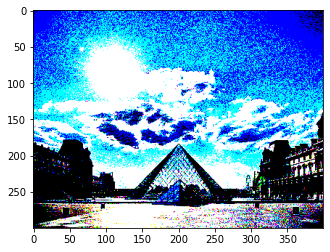

In [27]:
display(generated_image[0])
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("J = ",sess.run(J))
# now train your model
sess.run(train_step)
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("J = ",sess.run(J))
generated_image = sess.run(model['input'])
display(generated_image.shape)
display(generated_image[0])
imshow(generated_image[0])

array([[[-42.450233  , -16.23355   ,  -5.876776  ],
        [-38.82893   , -12.681717  ,   9.000797  ],
        [-43.739456  , -12.491934  ,  -0.6363632 ],
        ...,
        [-28.344269  , -20.403688  , -12.680779  ],
        [-37.4669    , -16.209398  ,   5.1569543 ],
        [-33.357304  , -23.49673   ,  -8.034605  ]],

       [[-45.449333  , -23.947058  ,  15.307848  ],
        [-28.883228  , -15.25836   ,   4.2882905 ],
        [-31.274586  , -27.2176    ,   4.4523535 ],
        ...,
        [-38.12903   , -29.611341  ,  -5.798461  ],
        [-47.175144  , -16.077595  ,  -4.992507  ],
        [-46.989956  , -35.203304  ,   1.6692046 ]],

       [[-34.562588  , -26.445066  ,  14.409604  ],
        [-45.301163  , -21.873497  ,  10.799737  ],
        [-32.502094  , -22.21818   ,  -4.533162  ],
        ...,
        [-45.96032   , -32.160347  ,  -6.9979353 ],
        [-33.33062   , -38.356     , -14.25777   ],
        [-29.37989   , -33.202873  ,  -0.65716696]],

       ...,

      

a_C_unrolled =  [[140.70317    107.45617    105.12337    ...  -0.          -0.
   -0.        ]
 [ 35.643764    49.380577    50.56549    ...  -0.          -0.
   -0.        ]
 [  3.4616046   -0.          -0.         ...  -0.          -0.
   -0.        ]
 ...
 [ 46.861485    72.59455     70.76873    ... 113.39476    115.304794
   68.263405  ]
 [ -0.          -0.          -0.         ...  50.50196     49.07713
   -0.        ]
 [  0.25346297  -0.          -0.         ...  -0.          -0.
   -0.        ]]
a_G_unrolled =  [[43.58595  38.553234 46.444893 ... -0.       -0.       -0.      ]
 [13.8364   20.54716  19.720009 ... -0.       -0.       -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]
 ...
 [16.01552  28.922373 26.255825 ... 42.946438 48.29865  27.499304]
 [-0.       -0.       -0.       ... 20.174103 28.979696 -0.      ]
 [-0.       -0.       -0.       ... -0.       -0.       -0.      ]]
GS_list =  [array([[ 75195.75   ,   1094.3505 ,   5930.756  , ...,   

(1, 300, 400, 3)

array([[[-42.45015   , -16.233461  ,  -5.876689  ],
        [-38.828846  , -12.681632  ,   9.000884  ],
        [-43.739372  , -12.491847  ,  -0.63627857],
        ...,
        [-28.344185  , -20.403605  , -12.680695  ],
        [-37.466816  , -16.209314  ,   5.157035  ],
        [-33.35722   , -23.496649  ,  -8.034529  ]],

       [[-45.44925   , -23.94697   ,  15.307934  ],
        [-28.883142  , -15.258273  ,   4.288377  ],
        [-31.2745    , -27.217512  ,   4.452439  ],
        ...,
        [-38.128944  , -29.611256  ,  -5.7983747 ],
        [-47.17506   , -16.077509  ,  -4.9924226 ],
        [-46.989872  , -35.20322   ,   1.6692841 ]],

       [[-34.562504  , -26.444979  ,  14.409691  ],
        [-45.301075  , -21.87341   ,  10.799824  ],
        [-32.502007  , -22.218092  ,  -4.533078  ],
        ...,
        [-45.960236  , -32.16026   ,  -6.997851  ],
        [-33.330536  , -38.35591   , -14.257684  ],
        [-29.379805  , -33.20279   ,  -0.65708226]],

       ...,

      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


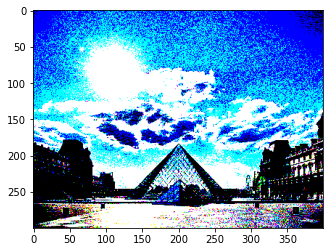

In [26]:
display(generated_image[0])
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("J = ",sess.run(J))
# now train your model
sess.run(train_step)
print("a_C_unrolled = ",sess.run(a_C_unrolled))
print("a_G_unrolled = ",sess.run(a_G_unrolled))
print("GS_list = ",sess.run(GS_list))
print("GG_list = ",sess.run(GG_list))
print("J = ",sess.run(J))
generated_image = sess.run(model['input'])
display(generated_image.shape)
display(generated_image[0])
imshow(generated_image[0])

Run the following cell to generate an artistic image. It should take about 3min on CPU for every 20 iterations but you start observing attractive results after ≈140 iterations. Neural Style Transfer is generally trained using GPUs.

In [ ]:
model_nn(sess, generated_image)

**Expected Output**:

<table>
    <tr>
        <td>
            **Iteration 0 : **
        </td>
        <td>
           total cost = 5.05035e+09 <br>
           content cost = 7877.67 <br>
           style cost = 1.26257e+08
        </td>
    </tr>

</table>

You're done! After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

You should see something the image presented below on the right:

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

We didn't want you to wait too long to see an initial result, and so had set the hyperparameters accordingly. To get the best looking results, running the optimization algorithm longer (and perhaps with a smaller learning rate) might work better. After completing and submitting this assignment, we encourage you to come back and play more with this notebook, and see if you can generate even better looking images. 

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">

## 5 - Test with your own image (Optional/Ungraded)

Finally, you can also rerun the algorithm on your own images! 

To do so, go back to part 4 and change the content image and style image with your own pictures. In detail, here's what you should do:

1. Click on "File -> Open" in the upper tab of the notebook
2. Go to "/images" and upload your images (requirement: (WIDTH = 300, HEIGHT = 225)), rename them "my_content.png" and "my_style.png" for example.
3. Change the code in part (3.4) from :
```python
content_image = scipy.misc.imread("images/louvre.jpg")
style_image = scipy.misc.imread("images/claude-monet.jpg")
```
to:
```python
content_image = scipy.misc.imread("images/my_content.jpg")
style_image = scipy.misc.imread("images/my_style.jpg")
```
4. Rerun the cells (you may need to restart the Kernel in the upper tab of the notebook).

You can also tune your hyperparameters: 
- Which layers are responsible for representing the style? STYLE_LAYERS
- How many iterations do you want to run the algorithm? num_iterations
- What is the relative weighting between content and style? alpha/beta

## 6 - Conclusion

Great job on completing this assignment! You are now able to use Neural Style Transfer to generate artistic images. This is also your first time building a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them! 

<font color='blue'>
What you should remember:
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




This was the final programming exercise of this course. Congratulations--you've finished all the programming exercises of this course on Convolutional Networks! We hope to also see you in Course 5, on Sequence models! 


### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
